In [1]:
import sys

import pickle
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import util_local as ul
from scipy import optimize, integrate

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 

### Calculates instantaneous growth rate from cell volume measurements. Cell volume timeseries dataset used to produce the following analysis can be found at: https://github.com/Si-Lab-CMU/Power-law-memory-governs-bacterial-adaptation-and-learning-in-fluctuating-environments

`cells['f04p0101t0118r02']`

[
 'abs_times',
 'areas',
 'bboxes',
 'birth_label',
 'birth_time',
 'centroids',
 'daughters',
 'death',
 'delta',
 'die',
 'divide',
 'division_time',
 'elong_rate',
 'fov',
 'grow',
 'id',
 'labels',
 'lengths',
 'lengths_w_div',
 'orientations',
 'parent',
 'peak',
 'print_info',
 'sb',
 'sd',
 'septum_position',
 'tau',
 'times',
 'times_w_div',
 'volumes',
 'volumes_w_div',
 'width',
 'widths',
 'widths_w_div']
 
 
[
 'abs_times',
 'areas',
 'bboxes',
 'birth_label',
 'birth_time',
 'centroids',
 'daughters',
 'death',
 'delta',
 'die',
 'divide',
 'division_time',
 'elong_rate',
 'fl_area_avgs',
 'fl_tots',
 'fl_vol_avgs',
 'fov',
 'grow',
 'id',
 'labels',
 'lengths',
 'lengths_w_div',
 'orientations',
 'parent',
 'peak',
 'print_info',
 'sb',
 'sd',
 'septum_position',
 'tau',
 'times',
 'times_w_div',
 'volumes',
 'volumes_w_div',
 'width',
 'widths',
 'widths_w_div']
 
 

In [2]:
def cell_lists(cells):
    """
    For a given cell (dict from loading .pkl file),
    with fluorescent infomation, 
    Return a list of properties.
    """
    fl_list = []
    gr_list = []
    br_list = []
    ln_list = []
    tc_list = []
    for c in cells:
        f = cells[c].fl_vol_avgs
        f = np.array(f)
        f = f[np.nonzero(f)]
        if len(f)==0:
            continue # skip the loop if there is no fluorescent signal
        else:
            f = np.mean(f)
        gr = cells[c].elong_rate
#         br = cells[c].birth_time
        ln = cells[c].lengths[-1]
        ts = np.array(cells[c].abs_times)/60/60
        tc = ts[-1]-ts[0]
        br = ts[0]
        

        fl_list.append(f)
        gr_list.append(gr)
        br_list.append(br)
        ln_list.append(ln)
        tc_list.append(tc)

    fl_list = np.array(fl_list)
    gr_list = np.array(gr_list)
    br_list = np.array(br_list)
    ln_list = np.array(ln_list)
    tc_list = np.array(tc_list)
    
    return fl_list, gr_list, br_list, ln_list, tc_list

In [3]:
# analysis folder
fig_folder = "../4_figure/"
ul.create_folder(fig_folder)

def load_files(analyz_folder="../1_nd2/3_analysis/analysis_mm3/"):
    
    """
    Load the data for a given analysis folder"""
    
    analyz_folder = ul.folder_verify(analyz_folder)
    all_cells_f, cells_f, cellfl_f, time_table_f= paths(analyz_folder)

    with open(all_cells_f, "rb") as f: 
        call = pickle.load(f)
    with open(cells_f,"rb") as f:
        cell = pickle.load(f)
    with open(cellfl_f,"rb") as f:
        cell_fl = pickle.load(f)
    with open(time_table_f, "r") as f:
        time_table = yaml.safe_load(f)
    
    return call, cell, cell_fl, time_table

def cell_paths_phase(analyz_folder):
    
    # files
    all_cells_f = ul.folder_file_num(analyz_folder, "cell_data", logs=0)[0] + "/"+"all_cells.pkl"
    cells_f = ul.folder_file_num(analyz_folder, "cell_data", logs=0)[0] + "/"+"complete_cells.pkl"
    time_table_f = ul.folder_file_num(analyz_folder, "time_table.yaml", logs=0)[0]
    
    return all_cells_f, cells_f, time_table_f

def load_files_phase(analyz_folder="../1_nd2/3_analysis/analysis_mm3/"):
    
    """
    Load the data for a given analysis folder"""
    
    analyz_folder = ul.folder_verify(analyz_folder)
    all_cells_f, cells_f, time_table_f= cell_paths_phase(analyz_folder)

    with open(all_cells_f, "rb") as f: 
        call = pickle.load(f)
    with open(cells_f,"rb") as f:
        cell = pickle.load(f)
    with open(time_table_f, "r") as f:
        time_table = yaml.safe_load(f)
    
    return call, cell, time_table

../4_figure/ folder exists.



In [4]:
def rolling_plot(x_list, y_list, x_maxrange, y_maxrange, 
                 x_label, y_label, figname, vlines = None, 
                 figfolder = "./",
                 window = 0.05, sliding = 1, min_n = 5, 
                 alpha = 0.1, l_width = 2,
                 quantile_inv = [0,1], fig_size = (8,3)
                ):
    """ 
    x_list - list of float
    y_list - list of float
    x_maxrange - float
    
    window - float, parameter for window size (percentage)
    sliding - float, parameter for walking distance (percentage)
    min_n - minum number of points in window to include in plot
    """

    xs_min, xs_max = np.quantile(x_list, quantile_inv)
    window_size = (xs_max-xs_min)*window
    slid_distance = window_size*sliding
    xs = np.arange(start = xs_min, stop = xs_max, step = slid_distance)

    xs_list = [] 

    data_frame = []
    mean = []
    median = []
    quantile25 = []
    quantile75 = []
    i = 0
    while i<len(xs)-1:


        data_bin = y_list[(x_list>=xs[i])&(x_list<xs[i]+window_size)]
        if len(data_bin)>min_n:
            data_frame.append(data_bin)
            mea = np.mean(data_bin)
            med = np.median(data_bin)
            q25 = np.quantile(data_bin, 0.25)
            q75 = np.quantile(data_bin, 0.75)
            mean.append(mea)
            median.append(med)
            quantile25.append(q25)
            quantile75.append(q75)

            xs_list.append(xs[i])

        if xs[i]+window_size> x_maxrange:
            break

        i = i+1

    xs_list = np.asarray(xs_list)
    mean = np.asarray(mean)
    median = np.asarray(median)
    quantile25 = np.asarray(quantile25)
    quantile75 = np.asarray(quantile75)

    plt.figure(figsize=fig_size)
    ax = plt.subplot(111)
    if vlines:
        ax.vlines(np.asarray(vlines), 
                  ymin = 0, ymax = y_maxrange, 
                  colors = "k", linewidths = 0.8, linestyles = "--")

    ax.scatter(x_list[x_list<x_maxrange], y_list[x_list<x_maxrange], 
               marker = ".", s = 10, linewidth=0, c="#D2D2D2", alpha=alpha)
    ax.fill_between(xs_list+0.5*window_size, quantile25, quantile75, alpha=0.2)
    ax.plot(xs_list+0.5*window_size, median, lw = l_width, c = "dodgerblue")
#     ax.scatter(xs_list+0.5*window_size, median, lw = 0, marker = ".", s = 150, c = "orange")
    

    ax.spines[['right', 'top']].set_visible(False)
    
    # plt.xticks(xs_list)
    plt.xlim((np.min(x_list), x_maxrange*1.1))
    plt.ylim((-0.1, y_maxrange))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    
    figfolder = ul.folder_verify(figfolder)
    plt.savefig(figfolder+figname, dpi=200, bbox_inches="tight")
    plt.show()
    
    rolling_x = np.asarray(xs_list+0.5*window_size)
    
    return rolling_x, median


In [5]:
def paired_rolling_plot(x_list1, y_list1, x_maxrange1, y_maxrange1, 
                        x_list2, y_list2, x_maxrange2, y_maxrange2,
                        legend1, legend2,
                        x_label, y_label, figname, figfolder = "./",
                        window = 0.05, sliding = 0.3, min_n = 10, 
                        quantile_inv = [0.02, 0.98],
                        alpha1 = 0.8, alpha2 = 0.1,
                        scatter_c1 = "#D2D2D2", scatter_c2 = "#6495ED"
                       ):
    """ 
    x_list - list of float
    y_list - list of float
    x_maxrange - float
    
    window - float, parameter for window size (percentage)
    sliding - float, parameter for walking distance (percentage)
    """

    
    def rolling_calc(x_list, y_list, x_maxrange):
        window_size = x_maxrange*window
        slid_distance = window_size*sliding
        
        xs_min, xs_max = np.quantile(x_list, quantile_inv)
        xs = np.arange(start = xs_min, stop = xs_max, step = slid_distance)

        xs_list = [] 

        data_frame = []
        mean = []
        median = []
        quantile25 = []
        quantile75 = []
        i = 0
        while i<len(xs)-1:


            data_bin = y_list[(x_list>=xs[i])&(x_list<xs[i]+window_size)]
            if len(data_bin)>min_n: # make sure the intervel is not empty
                data_frame.append(data_bin)
                mea = np.mean(data_bin)
                med = np.median(data_bin)
                q25 = np.quantile(data_bin, 0.25)
                q75 = np.quantile(data_bin, 0.75)
                mean.append(mea)
                median.append(med)
                quantile25.append(q25)
                quantile75.append(q75)

                xs_list.append(xs[i])

            if xs[i]+window_size> x_maxrange:
                break

            i = i+1

        xs_list = np.array(xs_list)
        
        return xs_list, mean, median, window_size
    
    xs_list_1, mean_1, median_1, window_size_1 = rolling_calc(x_list1, y_list1, x_maxrange1)
    xs_list_2, mean_2, median_2, window_size_2 = rolling_calc(x_list2, y_list2, x_maxrange2)
    
    plt.figure(figsize=(4,3))
    ax = plt.subplot(111)

    ax.scatter(x_list1[x_list1<x_maxrange1], y_list1[x_list1<x_maxrange1], 
               label = legend1,
               marker = ".", s = 16, linewidth=0, c=scatter_c1, alpha=alpha1)
    ax.scatter(x_list2[x_list2<x_maxrange2], y_list2[x_list2<x_maxrange2], 
               label = legend2,
               marker = ".", s = 16, linewidth=0, c=scatter_c2, alpha=alpha2)
#     ax.fill_between(xs_list+0.5*window_size, quantile25, quantile75, alpha=0.2)
    ax.plot(xs_list_1+0.5*window_size_1, median_1, lw = 1.8)
    ax.plot(xs_list_2+0.5*window_size_2, median_2, lw = 1.8)

    ax.spines[['right', 'top']].set_visible(False)
    
    plt.legend(frameon = False, fontsize = 9, loc='upper right')
    
    # plt.xticks(xs_list)
    plt.xlim((np.min([np.min(x_list1),np.min(x_list2)]), np.max([np.max(x_maxrange1), np.max(x_maxrange2)])*1.1))
    plt.ylim((0, np.max([y_maxrange1, y_maxrange2])))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    
    figfolder = ul.folder_verify(figfolder)
    plt.savefig(figfolder+figname, dpi=200, bbox_inches="tight")
    plt.show()
    
    
    
    return (np.asarray(xs_list_1+0.5*window_size_1), 
            np.asarray(median_1), 
            np.asarray(xs_list_2+0.5*window_size_2), 
            np.asarray(median_2))

In [6]:
analyz_folders = ul.folder_file_num("../1_nd2/3_analysis/new/", "analysis")
analyz_folders

../1_nd2/3_analysis/new/ has 7 files


['../1_nd2/3_analysis/new/analysis_0p5',
 '../1_nd2/3_analysis/new/analysis_1',
 '../1_nd2/3_analysis/new/analysis_1p5',
 '../1_nd2/3_analysis/new/analysis_2',
 '../1_nd2/3_analysis/new/analysis_3',
 '../1_nd2/3_analysis/new/analysis_down',
 '../1_nd2/3_analysis/new/analysis_up']

In [7]:
call_1, cel_1, time_table_1 = load_files_phase(analyz_folders[0]) # 0.5, per switch
call_2, cel_2, time_table_2 = load_files_phase(analyz_folders[1]) # 1
call_3, cel_3, time_table_3 = load_files_phase(analyz_folders[2]) # 1.5
call_4, cel_4, time_table_4 = load_files_phase(analyz_folders[3]) # 2
call_5, cel_5, time_table_5 = load_files_phase(analyz_folders[4]) # 3
call_down, cel_down, time_table_down = load_files_phase(analyz_folders[5]) # single downshift
call_up, cel_up, time_table_up = load_files_phase(analyz_folders[6]) # single upshift

### Computing exponential growth rate from 3 point fitting

In [12]:
def gr_n_points(cell_df, calc_window = 3):
    
    l_list = []
    t_list = []
    for c in cell_df:

        # skip slow growing cells
    #     print(cell_df[c].lengths, cell_df[c].abs_times)
        l = np.asarray(cell_df[c].lengths)
        t = np.asarray(cell_df[c].abs_times)/60./60.

        if len(t)!=len(l):
            l = np.asarray(cell_df[c].lengths_w_div)

        if len(l)>1 and len(t)==len(l):
    #         gr = np.polyfit(t, np.float64(np.log(l)), 1)[0]
    #         if gr>0.1:
                l_list.append(l)
                t_list.append(t)

    l_list = np.asarray(l_list, dtype=object)
    t_list = np.asarray(t_list, dtype=object)

    # rolling for each cell
    # alc_window = 3

    xt_list = []
    yg_list = []

    i = 0
    while i<len(l_list):

        l = np.asarray(l_list[i])
        t = np.asarray(t_list[i])

        j = calc_window
        while j<=len(l):
            l_sub = l[j-calc_window:j]
            t_sub = t[j-calc_window:j]
            r = np.polyfit(t_sub, np.float64(np.log(l_sub)), 1)[0]
            xt = t_sub.mean()
            xt_list.append(xt)
            yg_list.append(r)

            j = j+1
        i = i+1

    xt_list = np.asarray(xt_list)
    yg_list = np.asarray(yg_list)
    
    print("----------------END----------------------")

    return xt_list,yg_list

In [ ]:
xt_list_1,yg_list_1 = gr_n_points(cel_1, calc_window = 3)
xt_list_2,yg_list_2 = gr_n_points(cel_2, calc_window = 3)
xt_list_3,yg_list_3 = gr_n_points(cel_3, calc_window = 3)
xt_list_4,yg_list_4 = gr_n_points(cel_4, calc_window = 3)
xt_list_5,yg_list_5 = gr_n_points(cel_5, calc_window = 3)
xt_list_down,yg_list_down = gr_n_points(cel_down, calc_window = 3)
xt_list_up,yg_list_up = gr_n_points(cel_up, calc_window = 3)

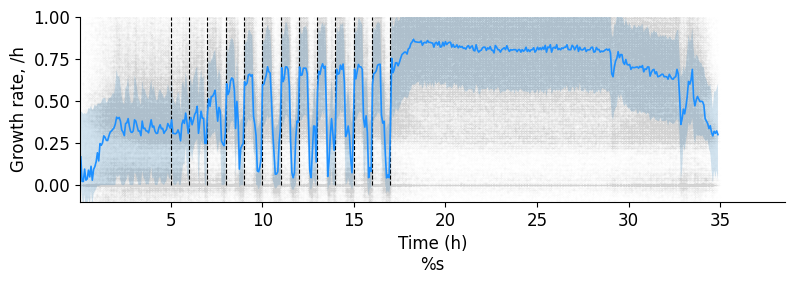

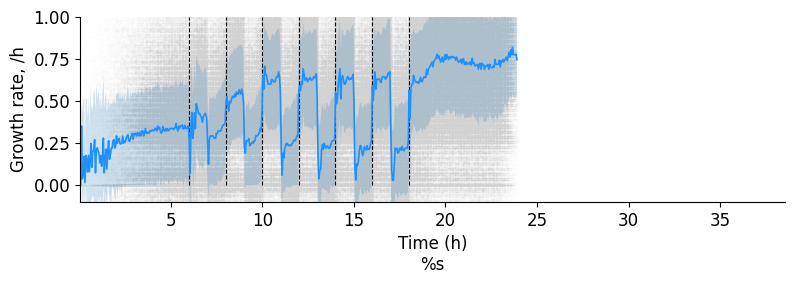

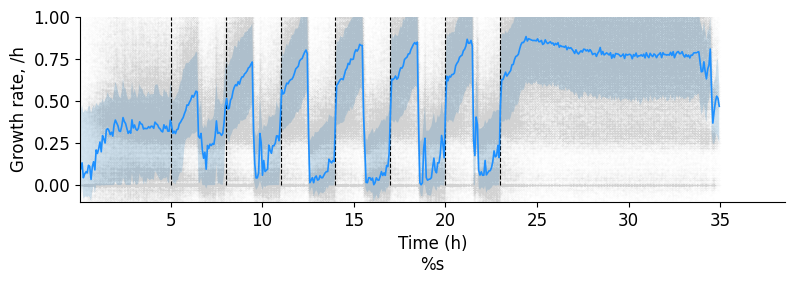

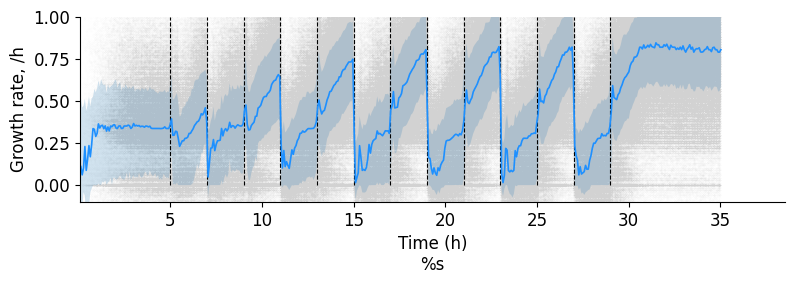

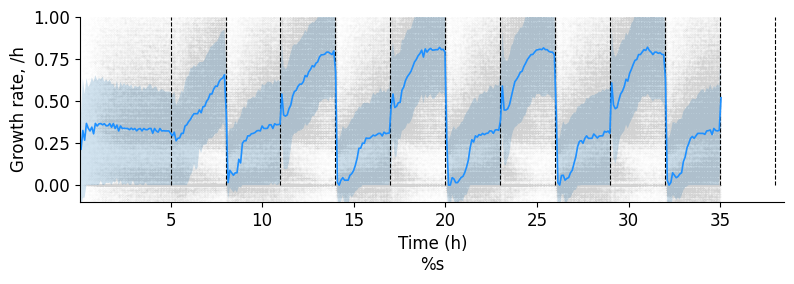

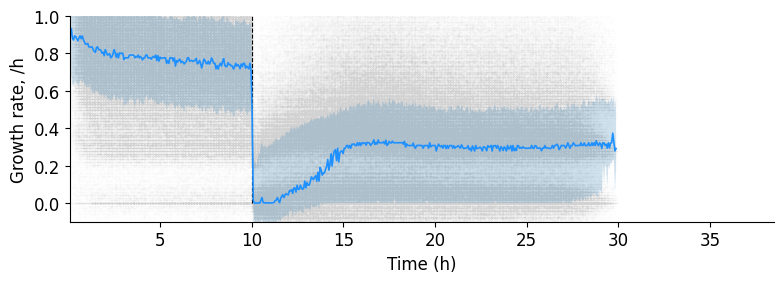

In [10]:
quantile_inv = [0,1]
sliding = 1.0
window = 0.002
x_maxrange = 35
vl1 = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
vl2 = [6, 8, 10, 12,  14, 16, 18]
vl3 = [5, 8, 11, 14,17, 20, 23]
vl4 = [5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
vl5 = [5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41]

gr3px_roll_1, gr3py_roll_1 = rolling_plot(x_list = xt_list_1, y_list = yg_list_1, 
                                          x_maxrange=x_maxrange, y_maxrange = 1, vlines=vl1,
                                          x_label = "Time (h)\n%s", y_label = "Growth rate, /h",
                                          figname = "gr3p_gr_vs_t_1_%s.png", 
                                          figfolder=fig_folder, 
                                          min_n = 5, alpha=0.01, l_width=1.2,
                                          window=window, sliding=sliding,
                                          quantile_inv=quantile_inv,
                                          fig_size=(8,3))

gr3px_roll_2, gr3py_roll_2 = rolling_plot(x_list = xt_list_2, y_list = yg_list_2, 
                                          x_maxrange = x_maxrange, y_maxrange = 1, vlines=vl2,
                                          x_label = "Time (h)\n%s", y_label = "Growth rate, /h",
                                          figname = "gr3p_gr_vs_t_2_%s.png", 
                                          figfolder = fig_folder, 
                                          min_n = 5, alpha=0.01, l_width=1.2,
                                          window=window, sliding = sliding,
                                          quantile_inv = quantile_inv,
                                          fig_size=(8,3))

gr3px_roll_3, gr3py_roll_3 = rolling_plot(x_list = xt_list_3, y_list = yg_list_3, 
                                          x_maxrange = x_maxrange, y_maxrange = 1, vlines=vl3,
                                          x_label = "Time (h)\n%s", y_label = "Growth rate, /h",
                                          figname = "gr3p_gr_vs_t_2_%s.png", 
                                          figfolder = fig_folder, 
                                          min_n = 5, alpha=0.01, l_width=1.2,
                                          window=window, sliding = sliding,
                                          quantile_inv = quantile_inv,
                                          fig_size=(8,3))

gr3px_roll_4, gr3py_roll_4 = rolling_plot(x_list = xt_list_4, y_list = yg_list_4, 
                                          x_maxrange = x_maxrange, y_maxrange = 1, vlines=vl4,
                                          x_label = "Time (h)\n%s", y_label = "Growth rate, /h",
                                          figname = "gr3p_gr_vs_t_2_%s.png", 
                                          figfolder = fig_folder, 
                                          min_n = 5, alpha=0.01, l_width=1.2,
                                          window=window, sliding = sliding,
                                          quantile_inv = quantile_inv,
                                          fig_size=(8,3))

gr3px_roll_5, gr3py_roll_5 = rolling_plot(x_list = xt_list_5, y_list = yg_list_5, 
                                          x_maxrange = x_maxrange, y_maxrange = 1, vlines=vl5,
                                          x_label = "Time (h)\n%s", y_label = "Growth rate, /h",
                                          figname = "gr3p_gr_vs_t_2_%s.png", 
                                          figfolder = fig_folder, 
                                          min_n = 5, alpha=0.01, l_width=1.2,
                                          window=window, sliding = sliding,
                                          quantile_inv = quantile_inv,
                                          fig_size=(8,3))

gr3px_roll_down, gr3py_roll_down = rolling_plot(x_list = xt_list_down, y_list = yg_list_down, 
                                          x_maxrange = x_maxrange, y_maxrange = 1, vlines=[10],
                                          x_label = "Time (h)", y_label = "Growth rate, /h",
                                          figname = "gr3p_gr_vs_t_2_%s.png", 
                                          figfolder = fig_folder, 
                                          min_n = 5, alpha=0.01, l_width=1.2,
                                          window=window, sliding = sliding,
                                          quantile_inv = quantile_inv,
                                          fig_size=(8,3))

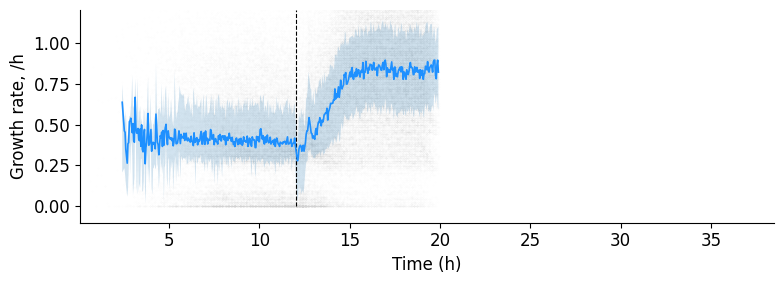

In [11]:
sliding = 1.0
window = 0.002

gr3px_roll_up, gr3py_roll_up = rolling_plot(x_list = xt_list_up[yg_list_up>0], y_list = yg_list_up[yg_list_up>0], 
                                          x_maxrange = x_maxrange, y_maxrange = 1.2, vlines=[12],
                                          x_label = "Time (h)", y_label = "Growth rate, /h",
                                          figname = "gr3p_gr_vs_t_2_%s.png", 
                                          figfolder = fig_folder, 
                                          min_n = 5, alpha=0.01, l_width=1.2,
                                          window=window, sliding = sliding,
                                          quantile_inv = quantile_inv,
                                          fig_size=(8,3))

In [ ]:
# Export data

exportdat = np.vstack((gr3px_roll_1,np.array(gr3py_roll_1)))
np.savetxt('0p5hrHuijingData_update.csv', exportdat.T, delimiter=',')

exportdat = np.vstack((gr3px_roll_2,np.array(gr3py_roll_2)))
np.savetxt('1hrHuijingData_update.csv', exportdat.T, delimiter=',')

exportdat = np.vstack((gr3px_roll_3,np.array(gr3py_roll_3)))
np.savetxt('1p5hrHuijingData_update.csv', exportdat.T, delimiter=',')

exportdat = np.vstack((gr3px_roll_4,np.array(gr3py_roll_4)))
np.savetxt('2hrHuijingData_update.csv', exportdat.T, delimiter=',')

exportdat = np.vstack((gr3px_roll_5,np.array(gr3py_roll_5)))
np.savetxt('3hrHuijingData_update.csv', exportdat.T, delimiter=',')

exportdat = np.vstack((gr3px_roll_down,np.array(gr3py_roll_down)))
np.savetxt('downshiftHuijingData_update.csv', exportdat.T, delimiter=',')

exportdat = np.vstack((gr3px_roll_up,np.array(gr3py_roll_up)))
np.savetxt('upshiftHuijingData_update.csv', exportdat.T, delimiter=',')

### Exponential fit to experimental data

0.09715682201572423 0.679457980513555


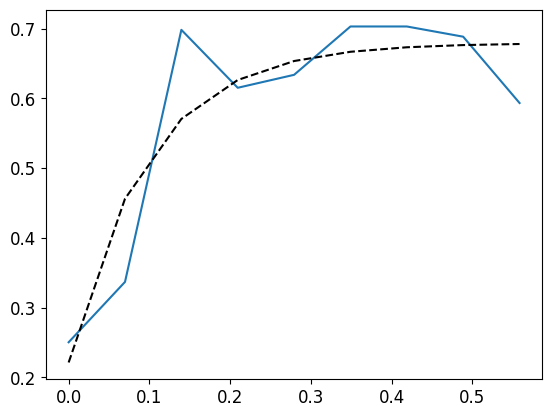

In [14]:
tau_up = []
tau_uncertainty = []
const_up = []
const_uncertainty = []

T = 1 # period
t = gr3px_roll_1-5
kappa = gr3py_roll_1

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>6 - 0.1) & (t<6+T/2)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,50,2]
popt, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up.append(popt[1])
tau_uncertainty.append(np.sqrt(pcov[1,1]))
const_uncertainty.append(np.sqrt(pcov[2,2]))
const_up.append(popt[2])
print(popt[1],popt[2])

plt.plot(t_fit,exp(t_fit,*popt), color='k', linestyle='--')
plt.show()

0.09687254671255487 0.6399009410001545


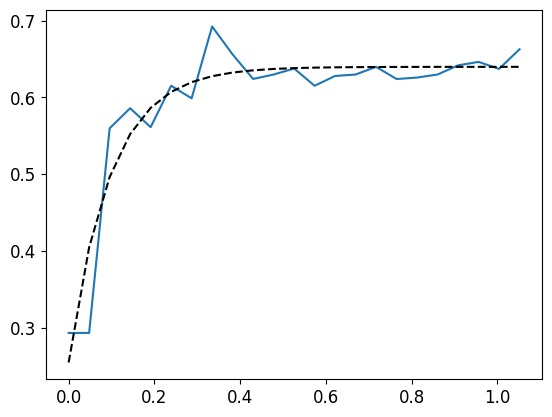

In [15]:
T = 2 # period
t = gr3px_roll_2-6
kappa = gr3py_roll_2

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>6 - 0.12) & (t<6+T/2 - 0.01)
t_real = t[ind]
t_fit2 = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit2,g_fit)

p0 = [-1,100,2]
popt2, pcov = optimize.curve_fit(exp, t_fit2, g_fit, p0=p0)
tau_up.append(popt2[1])
tau_uncertainty.append(np.sqrt(pcov[1,1]))
const_uncertainty.append(np.sqrt(pcov[2,2]))
const_up.append(popt2[2])
print(popt2[1],popt2[2])

plt.plot(t_fit2,exp(t_fit2,*popt2), color='k', linestyle='--')
plt.show()

0.5607854355937649 0.7972156774572519


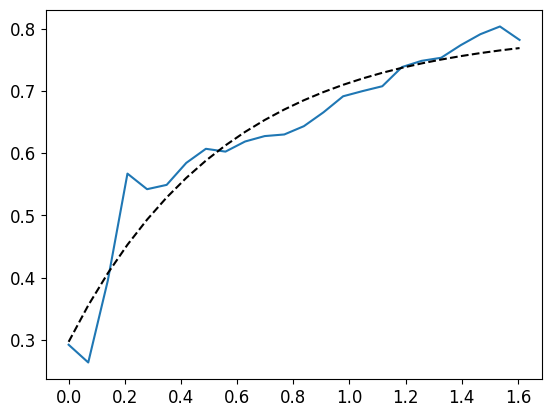

In [16]:
T = 3 # period
t = gr3px_roll_3-5
kappa = gr3py_roll_3

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>6-0.15) & (t<6+T/2 - 0.0)
t_real = t[ind]
t_fit3 = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit3,g_fit)

p0 = [-1,100,2]
popt3, pcov = optimize.curve_fit(exp, t_fit3, g_fit, p0=p0)
tau_up.append(popt3[1])
tau_uncertainty.append(np.sqrt(pcov[1,1]))
const_uncertainty.append(np.sqrt(pcov[2,2]))
const_up.append(popt3[2])
print(popt3[1],popt3[2])

plt.plot(t_fit3,exp(t_fit3,*popt3), color='k', linestyle='--')
plt.show()

1.5206951699508697 0.9118260617434434


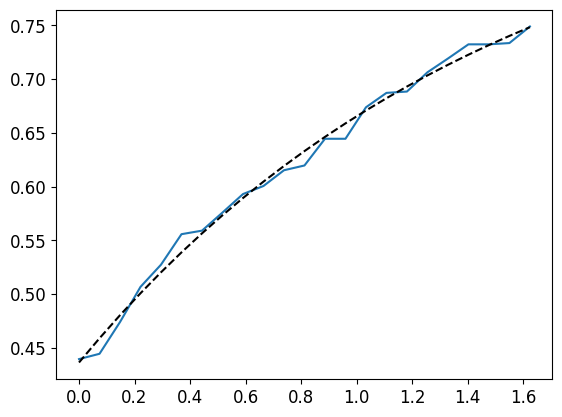

In [17]:
T = 4 # period
t = gr3px_roll_4-5
kappa = gr3py_roll_4

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>6+T/2 + 0.3) & (t<6+T - 0.03)
# ind = (t>6+T/2 + 0.2) & (t<6+T - 0.03)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,150,2]
popt4, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up.append(popt4[1])
tau_uncertainty.append(np.sqrt(pcov[1,1]))
const_uncertainty.append(np.sqrt(pcov[2,2]))
const_up.append(popt4[2])
print(popt4[1],popt4[2])

plt.plot(t_fit,exp(t_fit,*popt4), color='k', linestyle='--')
plt.show()

1.7514277522222859 0.9191986741188621


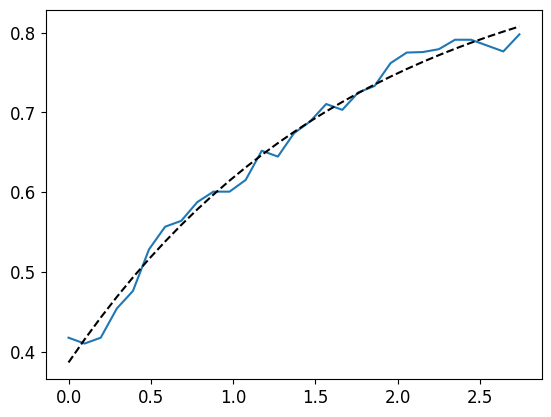

In [18]:
T = 6 # period
t = gr3px_roll_5-5
kappa = gr3py_roll_5

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>6 + 0.1) & (t<6+T/2 )
# ind = (t>6 + 0.1) & (t<6+T/2 -0.1)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,100,2]
popt6, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up.append(popt6[1])
tau_uncertainty.append(np.sqrt(pcov[1,1]))
const_uncertainty.append(np.sqrt(pcov[2,2]))
const_up.append(popt6[2])
print(popt6[1],popt6[2])

plt.plot(t_fit,exp(t_fit,*popt6), color='k', linestyle='--')
plt.show()

2.0023726647063937 0.9766405871521477


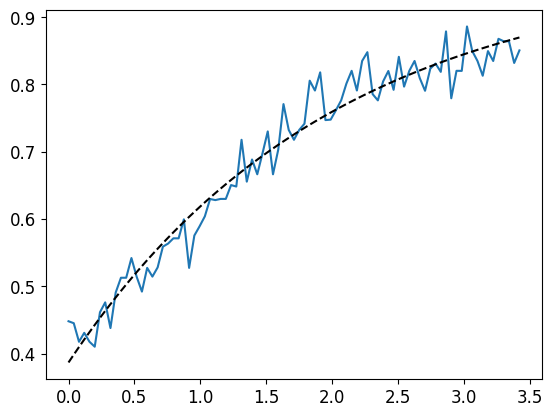

In [19]:
T = np.Inf # period
t = gr3px_roll_up-12.3
kappa = gr3py_roll_up

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>0.55) & (t<4)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,100,2]
poptinf, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up.append(poptinf[1])
tau_uncertainty.append(np.sqrt(pcov[1,1]))
const_uncertainty.append(np.sqrt(pcov[2,2]))
const_up.append(poptinf[2])
print(poptinf[1], poptinf[2])

plt.plot(t_fit,exp(t_fit,*poptinf), color='k', linestyle='--')
plt.show()

In [ ]:
period = np.array([1, 2, 3, 4, 6])
exportdat = np.vstack((period,tau_up))
np.savetxt('TvTau_upHuijing.csv', exportdat.T, delimiter=',') # saving for use in Figure 3d

### Figure 1d

In [20]:
T_const = lambda T_inv,a,b: (b*T_inv)**-a

[1.44882449 3.85460056]


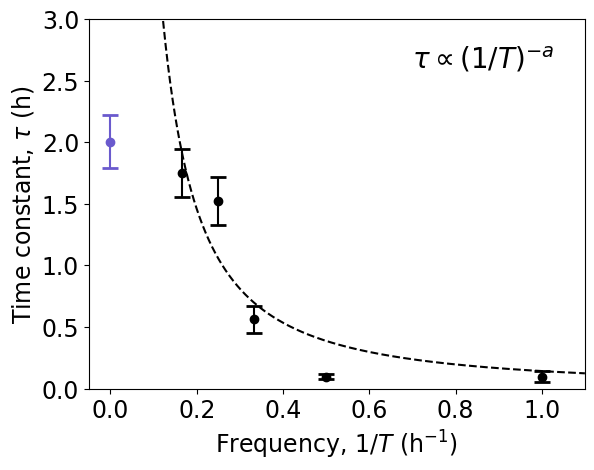

In [21]:
plt.rc('font', size=17)
fig = plt.figure()

period = np.array([1, 2, 3, 4, 6])
p0 = [0.4,0.1]
popt, pcov = optimize.curve_fit(T_const, 1/period, tau_up[:-1], p0=p0)
print(popt)

plt.errorbar(1/period,tau_up[:-1],yerr=tau_uncertainty[:-1],fmt='o', capsize=6, capthick=2, color='k')
plt.errorbar(1/np.Inf,tau_up[-1],yerr=tau_uncertainty[-1],fmt='o', capsize=6, capthick=2, color='slateblue')
x = np.linspace(0.01,1.1,1000)
plt.plot(x, T_const(x,*popt), color='k', linestyle='--')

plt.xlabel('Frequency, $1/T$ (h$^{-1}$)') 
plt.ylabel('Time constant, $\\tau$ (h)')
plt.ylim(0,3)
plt.xlim(-0.05,1.1)
plt.annotate('$\\tau \propto (1/T)^{-a}$', xy=(0.7,2.6), size=20)
plt.show()

### Figure 1c

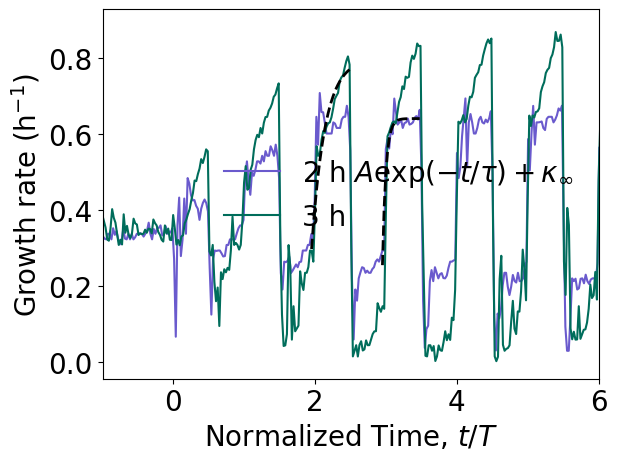

In [22]:
plt.rc('font', size=20)
fig = plt.figure()
plt.plot((gr3px_roll_2-6)/2, gr3py_roll_2, color='slateblue', alpha=1, label='2 h $A$exp$(-t/\\tau)+\kappa_{\infty}$')
plt.plot((gr3px_roll_3-5)/3, gr3py_roll_3, color='#006D5B', alpha=1, label='3 h')

plt.plot((t_fit2+5.9)/2,exp(t_fit2,*popt2), color='k', linestyle='--', linewidth=2)
plt.plot((t_fit3+5.85)/3,exp(t_fit3,*popt3), color='k', linestyle='--', linewidth=2)
plt.xlabel('Normalized Time, $t/T$')
plt.ylabel('Growth rate (h$^{-1}$)')
plt.xlim(-1,6)
plt.legend(frameon=False)
plt.subplots_adjust(hspace=.0)

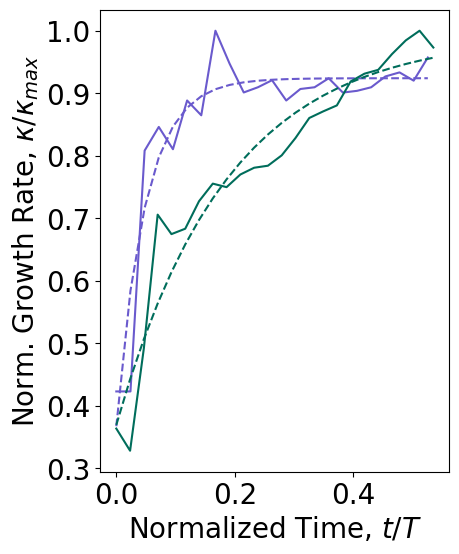

In [23]:
plt.rc('font', size=20)
fig = plt.figure(figsize=(3*1.5, 4*1.5))

T = 2 # period
t = gr3px_roll_2-6
kappa = gr3py_roll_2

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>6 - 0.12) & (t<6+T/2 - 0.01)
t_real = t[ind]
t_fit2 = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit2/2,g_fit/max(g_fit), color='slateblue')

p0 = [-1,100,2]
popt2, pcov = optimize.curve_fit(exp, t_fit2, g_fit, p0=p0)

plt.plot(t_fit2/2,exp(t_fit2,*popt2)/max(g_fit), color='slateblue', linestyle='--')


T = 3 # period
t = gr3px_roll_3-5
kappa = gr3py_roll_3

# Upshift
ind = (t>6-0.15) & (t<6+T/2 - 0.0)
t_real = t[ind]
t_fit3 = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit3/3,g_fit/max(g_fit), color='#006D5B')

p0 = [-1,100,2]
popt3, pcov = optimize.curve_fit(exp, t_fit3, g_fit, p0=p0)
plt.plot(t_fit3/3,exp(t_fit3,*popt3)/max(g_fit), color='#006D5B', linestyle='--')

plt.xlabel('Normalized Time, $t/T$')
plt.ylabel('Norm. Growth Rate, $\kappa/\kappa_{max}$')
plt.show()

### Exponential fit to dynamic-memory model

0.12858180663272997 0.6139323017519842


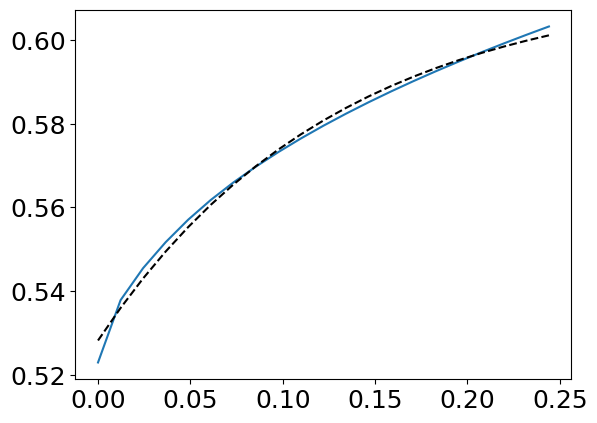

In [ ]:
tau_up_sim = []
const_up_sim = []

T = 0.5 # period
# importing dynamic memory model simulation results
df = pd.read_csv('simAll_dynMem_Fig3d/T_vs_tau_period0.5bias0.49913mem1.3kt01.85.csv').to_numpy()
t = df[:,0]
kappa = df[:,1]

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>6.75) & (t<6.75+T/2)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,100,2]
popt, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up_sim.append(popt[1])
const_up_sim.append(popt[2])
print(popt[1],popt[2])

plt.plot(t_fit,exp(t_fit,*popt), color='k', linestyle='--')
plt.show()

0.33413250000334144 0.6717707411995651


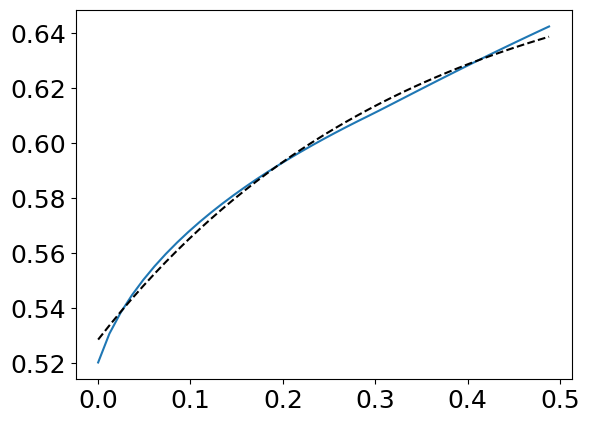

In [ ]:
T = 1 # period
df = pd.read_csv('simAll_dynMem_Fig3d/T_vs_tau_period1bias0.49913mem1.3kt01.85.csv').to_numpy()
t = df[:,0]
kappa = df[:,1]

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>6.5) & (t<6.5+T/2)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,100,2]
popt, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up_sim.append(popt[1])
const_up_sim.append(popt[2])
print(popt[1],popt[2])

plt.plot(t_fit,exp(t_fit,*popt), color='k', linestyle='--')
plt.show()

0.38638431254847583 0.6342621885702193


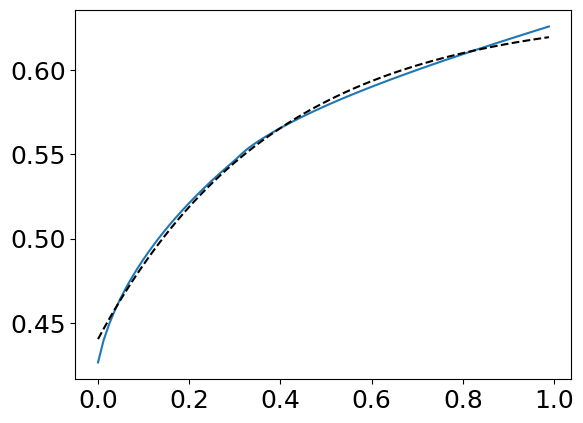

In [ ]:
T = 2 # period
df = pd.read_csv('simAll_dynMem_Fig3d/T_vs_tau_period2bias0.49913mem1.3kt01.85.csv').to_numpy()
t = df[:,0]
kappa = df[:,1]

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>7) & (t<7+T/2)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,50,2]
popt, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up_sim.append(popt[1])
const_up_sim.append(popt[2])
print(popt[1],popt[2])

plt.plot(t_fit,exp(t_fit,*popt), color='k', linestyle='--')
plt.show()

0.4632087664649054 0.6784319416574688


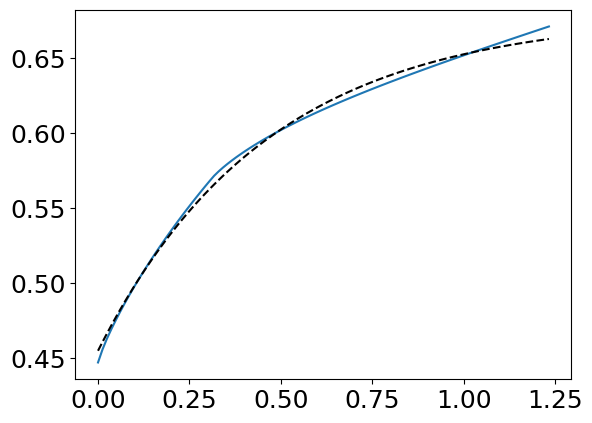

In [ ]:
T = 2.5 # period
df = pd.read_csv('simAll_dynMem_Fig3d/T_vs_tau_period2.5bias0.49913mem1.3kt01.85.csv').to_numpy()
t = df[:,0]
kappa = df[:,1]

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>6.25) & (t<6.25+T/2)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,50,2]
popt, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up_sim.append(popt[1])
const_up_sim.append(popt[2])
print(popt[1],popt[2])

plt.plot(t_fit,exp(t_fit,*popt), color='k', linestyle='--')
plt.show()

0.5901231347624133 0.696159756511634


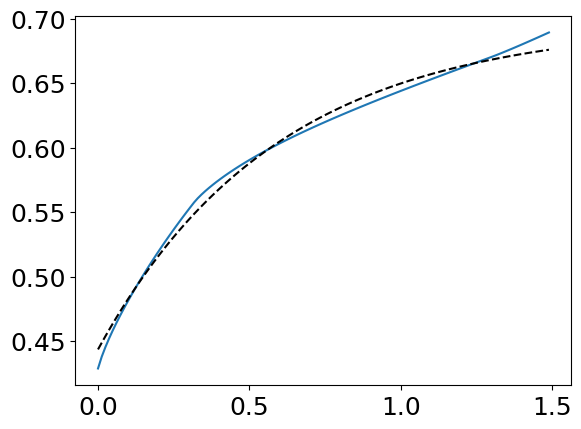

In [ ]:
T = 3 # period
df = pd.read_csv('simAll_dynMem_Fig3d/T_vs_tau_period3bias0.49913mem1.3kt01.85.csv').to_numpy()
t = df[:,0]
kappa = df[:,1]

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>7.5) & (t<7.5+T/2)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,100,2]
popt, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up_sim.append(popt[1])
const_up_sim.append(popt[2])
print(popt[1],popt[2])

plt.plot(t_fit,exp(t_fit,*popt), color='k', linestyle='--')
plt.show()

1.5491192460409586 0.7722394988609481


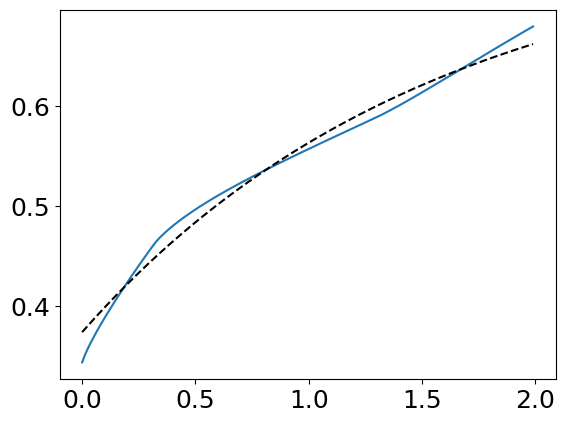

In [ ]:
T = 4 # period
df = pd.read_csv('simAll_dynMem_Fig3d/T_vs_tau_period4bias0.49913mem1.3kt01.85.csv').to_numpy()
t = df[:,0]
kappa = df[:,1]

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>6) & (t<6+T/2)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,100,2]
popt, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up_sim.append(popt[1])
const_up_sim.append(popt[2])
print(popt[1],popt[2])

plt.plot(t_fit,exp(t_fit,*popt), color='k', linestyle='--')
plt.show()

1.748438732896942 0.8867066550669835


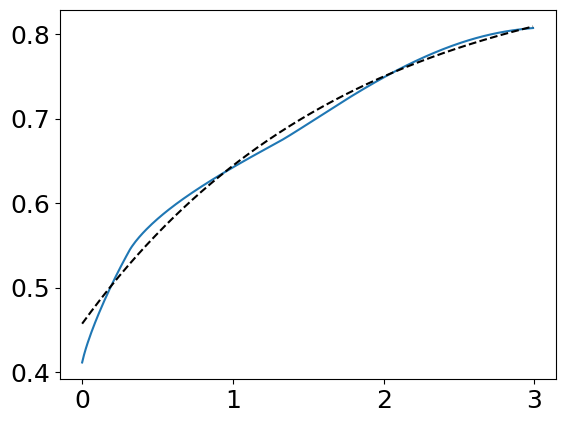

In [ ]:
T = 6 # period
df = pd.read_csv('simAll_dynMem_Fig3d/T_vs_tau_period6bias0.49913mem1.3kt01.85.csv').to_numpy()
t = df[:,0]
kappa = df[:,1]

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>9) & (t<9+T/2)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,100,2]
popt, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up_sim.append(popt[1])
const_up_sim.append(popt[2])
print(popt[1],popt[2])

plt.plot(t_fit,exp(t_fit,*popt), color='k', linestyle='--')
plt.show()

### Exponential fit to memoryless model

1.4672716151835294 0.9211810508525768


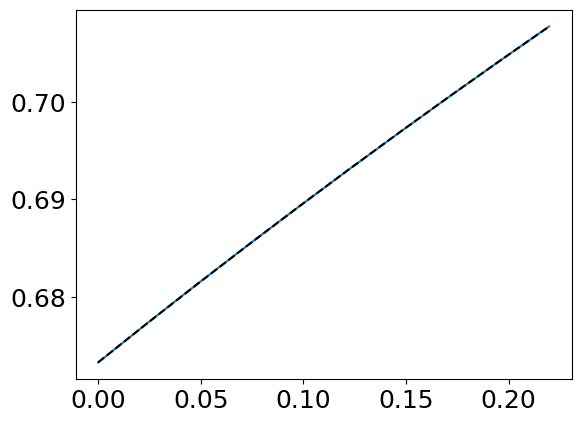

In [ ]:
tau_up_sim_memoryless = []
const_up_sim_memoryless = []

T = 0.5 # period
# importing memoryless model simulation results
df = pd.read_csv('simAll_memoryless_Fig3d/T_vs_tau_period0.5bias0mem1kt01.85.csv').to_numpy()
t = df[:,0]
kappa = df[:,1]

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>6.75) & (t<6.75+T/2)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,1,2]
popt, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up_sim_memoryless.append(popt[1])
const_up_sim_memoryless.append(popt[2])
print(popt[1],popt[2])

plt.plot(t_fit,exp(t_fit,*popt), color='k', linestyle='--')
plt.show()

1.7370955728363724 0.9603544674079297


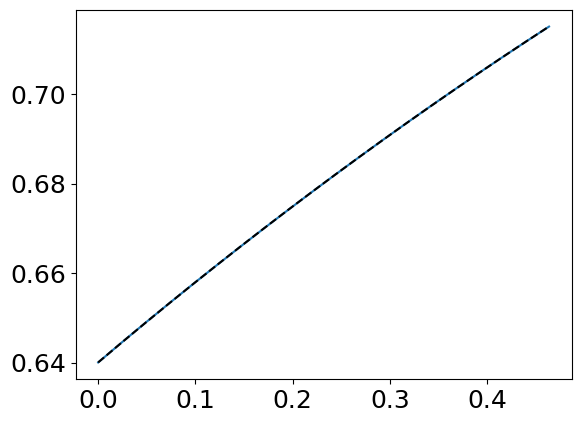

In [ ]:
T = 1 # period
df = pd.read_csv('simAll_memoryless_Fig3d/T_vs_tau_period1bias0mem1kt01.85.csv').to_numpy()
t = df[:,0]
kappa = df[:,1]

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>6.5) & (t<6.5+T/2)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,1,2]
popt, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up_sim_memoryless.append(popt[1])
const_up_sim_memoryless.append(popt[2])
print(popt[1],popt[2])

plt.plot(t_fit,exp(t_fit,*popt), color='k', linestyle='--')
plt.show()

1.776187426882168 0.9633651163844135


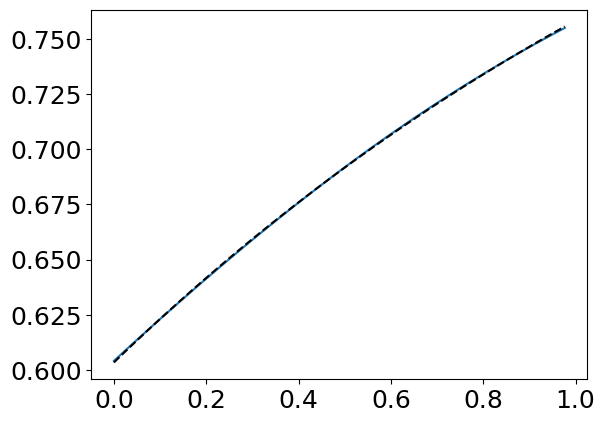

In [ ]:
T = 2 # period
df = pd.read_csv('simAll_memoryless_Fig3d/T_vs_tau_period2bias0mem1kt01.85.csv').to_numpy()
t = df[:,0]
kappa = df[:,1]

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>7) & (t<7+T/2)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,50,2]
popt, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up_sim_memoryless.append(popt[1])
const_up_sim_memoryless.append(popt[2])
print(popt[1],popt[2])

plt.plot(t_fit,exp(t_fit,*popt), color='k', linestyle='--')
plt.show()

1.751896992298481 0.9567571369170705


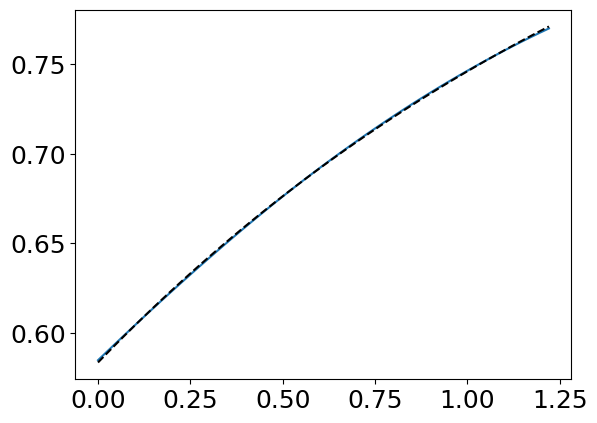

In [ ]:
T = 2.5 # period
df = pd.read_csv('simAll_memoryless_Fig3d/T_vs_tau_period2.5bias0mem1kt01.85.csv').to_numpy()
t = df[:,0]
kappa = df[:,1]

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>6.25) & (t<6.25+T/2)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,50,2]
popt, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up_sim_memoryless.append(popt[1])
const_up_sim_memoryless.append(popt[2])
print(popt[1],popt[2])

plt.plot(t_fit,exp(t_fit,*popt), color='k', linestyle='--')
plt.show()

1.616920001254984 0.9136590187553026


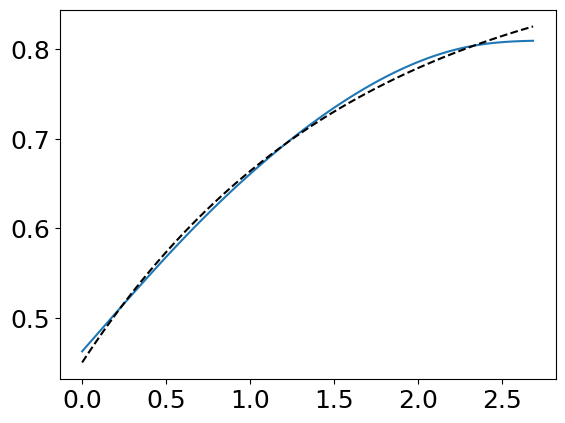

In [ ]:
T = 6 # period
df = pd.read_csv('simAll_memoryless_Fig3d/T_vs_tau_period6bias0mem1kt01.85.csv').to_numpy()
t = df[:,0]
kappa = df[:,1]

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>9) & (t<9+T/2-0.3)
t_real = t[ind]
t_fit = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit,g_fit)

p0 = [-1,100,2]
popt, pcov = optimize.curve_fit(exp, t_fit, g_fit, p0=p0)
tau_up_sim_memoryless.append(popt[1])
const_up_sim_memoryless.append(popt[2])
print(popt[1],popt[2])

plt.plot(t_fit,exp(t_fit,*popt), color='k', linestyle='--')
plt.show()

### Figure 3d

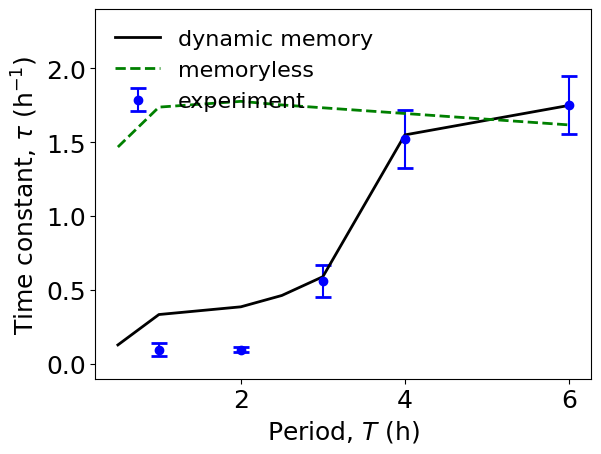

In [ ]:
plt.rc('font', size=18)
plt.rc('legend', fontsize=16)

fig = plt.figure()
period = np.array([1, 2, 3, 4, 6])
plt.errorbar(period,tau_up[:-1],yerr=tau_uncertainty[:-1],fmt='o', capsize=6, capthick=2, label='experiment', color='blue')
period = np.array([0.5, 1, 2, 2.5, 3, 4, 6])
plt.plot(period,tau_up_sim, color='k', linewidth=2, label='dynamic memory')
period = np.array([0.5, 1, 2, 2.5, 6])
plt.plot(period,tau_up_sim_memoryless, color='green', linestyle='--', linewidth=2, label='memoryless')
plt.ylim(-0.1,2.4)
plt.xlabel('Period, $T$ (h)')
plt.ylabel('Time constant, $\\tau$ (h$^{-1}$)')
plt.legend(frameon=False, loc='upper left')
plt.show()

### Figure 5c

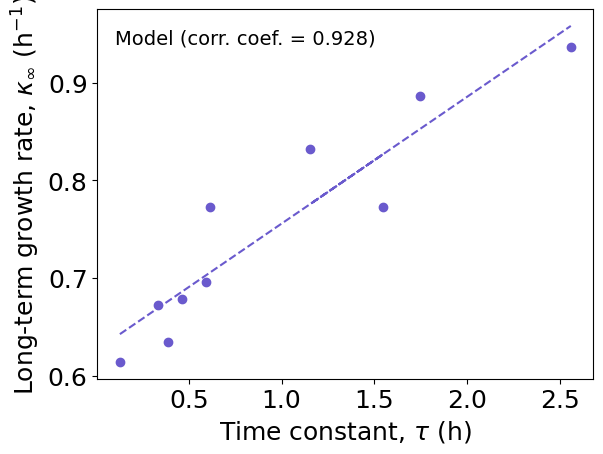

In [ ]:
corr_mat_sim = np.corrcoef(tau_up_sim,const_up_sim)

plt.rc('font', size=18)
fig = plt.figure()

m_sim,b_sim = np.polyfit(tau_up_sim,const_up_sim, 1)
fit = lambda x,m,b: m*x+b

plt.scatter(tau_up_sim,const_up_sim, color='slateblue')
plt.plot(tau_up_sim,fit(np.array(tau_up_sim),m_sim,b_sim), linestyle='--', color='slateblue')
plt.xlabel('Time constant, $\\tau$ (h)') 
plt.ylabel('Long-term growth rate, $\kappa_{\infty}$ (h$^{-1}$)')
plt.annotate('Model (corr. coef. = '+str(np.round(corr_mat_sim[0,1],3))+')', xy=(0.1, 0.94), fontsize=14)
plt.show()

### Figure 5b

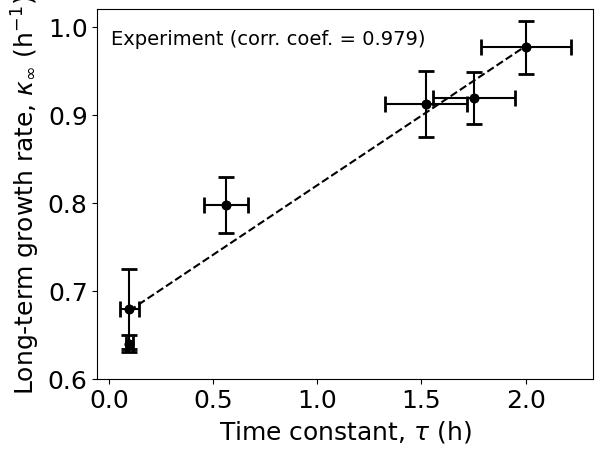

In [ ]:
corr_mat = np.corrcoef(tau_up,const_up)

plt.rc('font', size=18)
fig = plt.figure()

m,b = np.polyfit(tau_up,const_up, 1)
fit = lambda x,m,b: m*x+b

period = np.array([1, 2, 3, 4, 6, np.Inf])
plt.scatter(tau_up,const_up, color='k')
plt.errorbar(tau_up,const_up, xerr=tau_uncertainty, yerr=const_uncertainty, fmt='o', capsize=6, capthick=2, label='experiment', color='k')
plt.plot(tau_up,fit(np.array(tau_up),m,b), linestyle='--', color='k')
plt.xlabel('Time constant, $\\tau$ (h)') 
plt.ylabel('Long-term growth rate, $\kappa_{\infty}$ (h$^{-1}$)')
plt.annotate('Experiment (corr. coef. = '+str(np.round(corr_mat[0,1],3))+')', xy=(0.01, 0.98), fontsize=14)
plt.ylim(0.6,1.02)
plt.show()

### Change in adaptation with pulse (episodic learning)

0.42155918447953405 0.44295294002414937


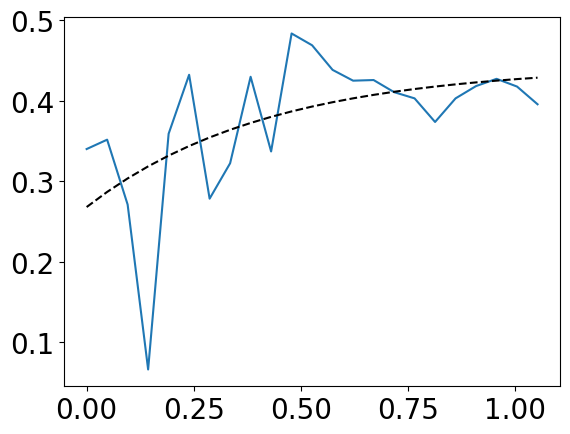

In [24]:
tau_up_seq = []
tau_uncertainty_seq = []

T = 2 # period
t = gr3px_roll_2-6
kappa = gr3py_roll_2

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>0 - 0.12) & (t<0+T/2 - 0.0)
t_real = t[ind]
t_fit2 = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit2,g_fit)

p0 = [-1,1,2]
popt2, pcov = optimize.curve_fit(exp, t_fit2, g_fit, p0=p0)
tau_up_seq.append(popt2[1])
tau_uncertainty_seq.append(np.sqrt(pcov[1,1]))
print(popt2[1],popt2[2])

plt.plot(t_fit2,exp(t_fit2,*popt2), color='k', linestyle='--')
plt.show()

0.2601661786576453 0.5557544982144983


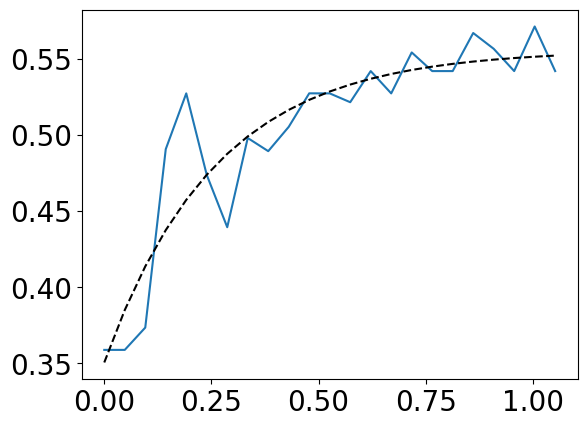

In [25]:
T = 2 # period
t = gr3px_roll_2-6
kappa = gr3py_roll_2

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>2 - 0.12) & (t<2+T/2 - 0.02)
t_real = t[ind]
t_fit2 = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit2,g_fit)

p0 = [-1,100,2]
popt2, pcov = optimize.curve_fit(exp, t_fit2, g_fit, p0=p0)
tau_up_seq.append(popt2[1])
tau_uncertainty_seq.append(np.sqrt(pcov[1,1]))
print(popt2[1],popt2[2])

plt.plot(t_fit2,exp(t_fit2,*popt2), color='k', linestyle='--')
plt.show()

0.09936526362385013 0.6359435903468577


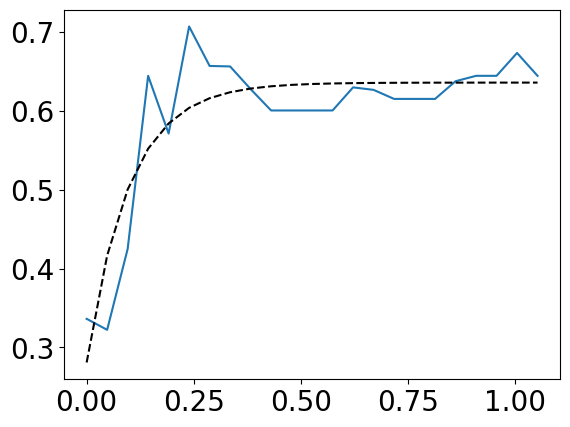

In [26]:
T = 2 # period
t = gr3px_roll_2-6
kappa = gr3py_roll_2

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>4 - 0.12) & (t<4+T/2 - 0.01)
t_real = t[ind]
t_fit2 = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit2,g_fit)

p0 = [-1,100,2]
popt2, pcov = optimize.curve_fit(exp, t_fit2, g_fit, p0=p0)
tau_up_seq.append(popt2[1])
tau_uncertainty_seq.append(np.sqrt(pcov[1,1]))
print(popt2[1],popt2[2])

plt.plot(t_fit2,exp(t_fit2,*popt2), color='k', linestyle='--')
plt.show()

0.09687254671255487 0.6399009410001545


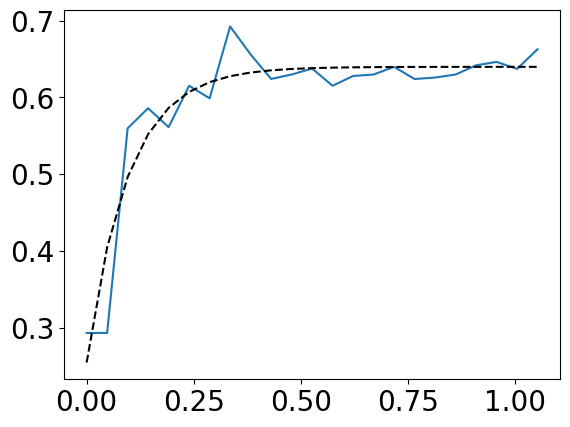

In [27]:
T = 2 # period
t = gr3px_roll_2-6
kappa = gr3py_roll_2

exp = lambda t,A,tau,b: A*np.exp(-t/tau) + b

# Upshift
ind = (t>6 - 0.12) & (t<6+T/2 - 0.01)
t_real = t[ind]
t_fit2 = t_real - min(t_real)
g_fit = kappa[ind]

plt.plot(t_fit2,g_fit)

p0 = [-1,100,2]
popt2, pcov = optimize.curve_fit(exp, t_fit2, g_fit, p0=p0)
tau_up_seq.append(popt2[1])
tau_uncertainty_seq.append(np.sqrt(pcov[1,1]))
print(popt2[1],popt2[2])

plt.plot(t_fit2,exp(t_fit2,*popt2), color='k', linestyle='--')
plt.show()

### Figure 1e

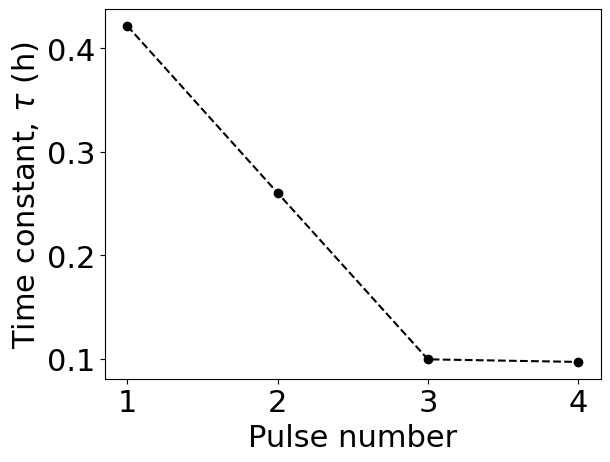

In [29]:
plt.rc('font', size=22)

fig = plt.figure()
pulse_num = np.array([1, 2, 3, 4])
plt.scatter(pulse_num,tau_up_seq, color='k')
plt.plot(pulse_num,tau_up_seq, color='k', linestyle='--')
plt.xlabel('Pulse number')
plt.ylabel('Time constant, $\\tau$ (h)')
plt.show()

### Calculating ave growth rate per half period

In [258]:
# defining regulatory functions and their derivatives

f = lambda a: 1 / (1 + (a/a_n)**n_f) # regulatory function for k_n
f_prime = lambda a: -(n_f/a_n)*(a/a_n)**(n_f-1) / (1 + (a/a_n)**n_f)**2 # derivative of f w.r.t. a

g = lambda a: (a/a_t)**n_g / (1 + (a/a_t)**n_g) # regulatory function for k_t
g_prime = lambda a: (n_g/a_t)*(a/a_t)**(n_g-1) / (1 + (a/a_t)**n_g)**2 # derivative of g w.r.t. a

# f_R, the fraction of total cell synthesis capacity devoted to ribosome production
f_R = lambda a: (-f_prime(a)*g(a)*phiR_max + f(a)*g_prime(a)*0.049) / (-f_prime(a)*g(a) + f(a)*g_prime(a))

In [259]:
# amino acid concentration ODE (variable nutrient conc.(c))

def dAAdt(a, t, phi_R):

    k_n0 = lambda t: (kn0_high - kn0_low) * (signal.square(2*np.pi*t/period + np.pi)/2 + 0.5) + kn0_low

    k_n = k_n0(t) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    dadt = k_n * (phiR_max - phi_R) - k_t * (phi_R - 0.049)
    return dadt

In [260]:
def dphiR_dt(phi_R, t, a):

    k_t = k_t0 * g(a) # translational efficiency

    dpdt = k_t * (phi_R - 0.049) * (f_R(a) - phi_R)
    return dpdt

In [261]:
# function for phi_R at steady state

def phiR_ss(a):

    k_n = kn0_low * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    return (k_n*phiR_max + k_t*0.049) / (k_n + k_t)

In [262]:
# packing coupled ODEs together to be solved by odeint

def odes(Species, t):

    phi_R,a = Species # Tuple unpacking of each species, equivalent to phi_R = Species[0] // a = Species[1]

    phiR_ode = dphiR_dt(phi_R, t, a)
    a_ode = dAAdt(a, t, phi_R)

    dSpeciesdt = [phiR_ode,a_ode]
    return dSpeciesdt

In [263]:
def func(x):
    return [phiR_ss(x[0]) - x[1], # x[0]=a, x[1]=phi_R
            f_R(x[0]) - x[1]]

In [264]:
def GrowthRate(a, phi_R):

    k_t = k_t0 * g(a)

    k = k_t * (phi_R - 0.049)
    return k

In [265]:
def Simulate(simulation_max, n_points):

    root = optimize.fsolve(func, [1e-4, 0.3]) # requires guess of initial conditions
    phi_R0 = root[1] # initial proteome fraction
    a0 = root[0] # initial amin acid concentration

    # Simulating and Plotting
    t = np.linspace(0,simulation_max,n_points)

    # Numerically solving the coupled ODEs
    species_0 = [phi_R0,a0]
    Species = integrate.odeint(odes, species_0, t)
    # Unpacking the Species matrix
    phi_R = Species[:,0]
    a = Species[:,1]

    return t, GrowthRate(a,phi_R)

In [266]:
# parameters
phiR_max = 0.55
a_t = 1e-4
a_n = 1e-3
# cooperativity of regulatory functions
n_f = 2
n_g = 2

In [267]:
from scipy import signal

In [268]:
kn0_high = 62.5401
kn0_low = 1.0078
k_t0 = 1.795

simulation_max = 18 # in hrs
n_points = 20000 #number of simulation points
period = 2 # time period of nutrient flucuations, in hrs

# Simulate and Plot model
time0,kappa0 = Simulate(simulation_max,n_points)

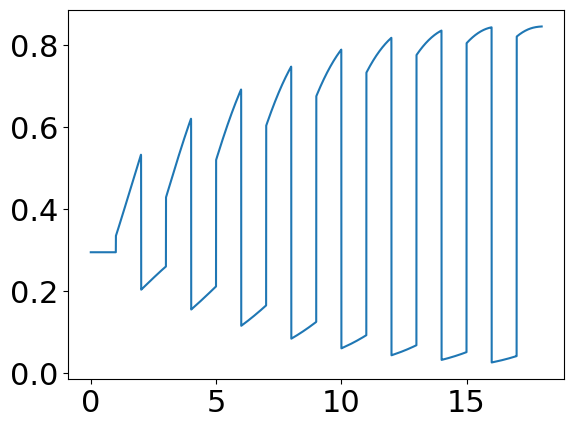

In [269]:
plt.plot(time0,kappa0)
plt.show()

In [270]:
# separating half-period data

def separation(GRate_ave):

    kap_low = GRate_ave[1:n_bins:2] # separating out half-periods of high nutrient concentration

    kap_high = GRate_ave[0:n_bins:2] # separating out half-periods of low nutrient concentration

    # computing average growth rate of each period
    kap_full = np.zeros(int((n_bins)/2))
    i=0
    for x in range(0,int((n_bins)/2)):
        kap_full[x] = sum(GRate_ave[i:i+2])/2
        i=i+2
    
    return kap_high, kap_low, kap_full

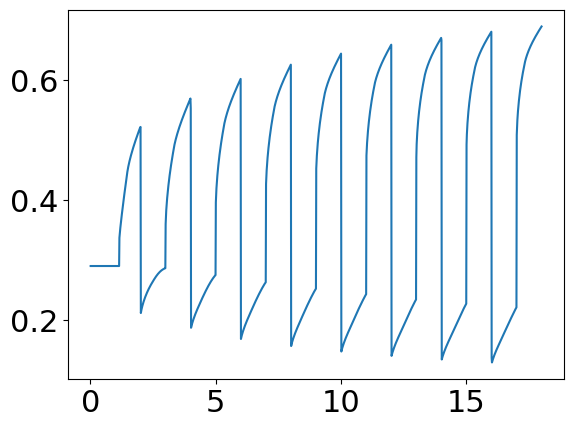

In [271]:
# df = pd.read_csv('T_vs_tau_period2bias0.49913mem1.2327kt01.795.csv').to_numpy()
df = pd.read_csv('T_vs_tau_period2bias0.49913mem1.3kt01.85.csv').to_numpy()
grx = df[:,0]
gry = df[:,1]

plt.plot(grx,gry)
plt.show()

In [272]:
# separating half-period data

def separation(GRate_ave):

    kap_low = GRate_ave[0:n_bins:2] # separating out half-periods of low nutrient concentration

    kap_high = GRate_ave[1:n_bins:2] # separating out half-periods of high nutrient concentration

    # computing average growth rate of each period
    kap_full = np.zeros(int((n_bins)/2)+1)
    kap_full[0] = kap_low[0]
    kap_high = np.concatenate(([kap_low[0]], kap_high))

    i=1
    for x in range(1,int((n_bins)/2)):
        kap_full[x] = sum(GRate_ave[i:i+2])/2
        i=i+2
    
    return kap_high, kap_low, kap_full

### Figure 3b

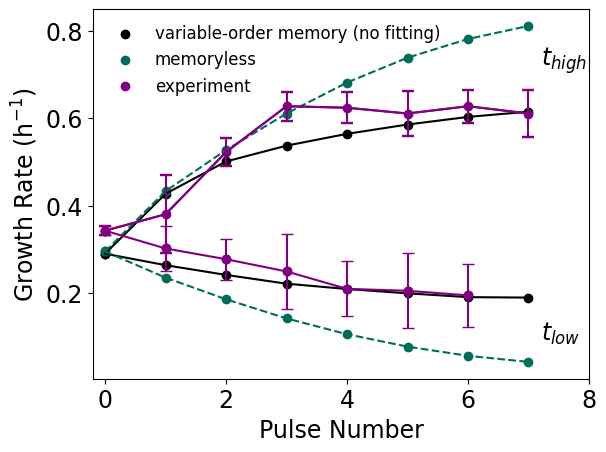

In [ ]:
plt.rc('font', size=17)
fig = plt.figure()


# calculate for simulations

n_bins = 16 # number of bins for averaging
t_min = 0
t_max = 16

time = np.linspace(t_min,t_max,n_bins+1)
GRate_ave = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points:
    if i < n_points-1:
        GRate_x = gry[(grx > time[i]) & (grx < time[i+1])]
        GRate_ave[i] = np.mean(GRate_x)
    else:
        GRate_x = gry[grx > time[i]]
        GRate_ave[i] = np.mean(GRate_x)
    i+=1

# Calculating transition time to fluctuation-adapted growth physiology
kap_high_sim, kap_low_sim, kap_full_sim = separation(GRate_ave)

# plotting growth rates
plt.scatter(range(0,len(kap_low_sim)), kap_low_sim, color='k')
plt.plot(range(0,len(kap_low_sim)), kap_low_sim, color='k')
plt.scatter(range(0,len(kap_high_sim)-1), kap_high_sim[:-1], color='k', label='variable-order memory (no fitting)')
plt.plot(range(0,len(kap_high_sim)-1), kap_high_sim[:-1], color='k')



# repeat calculations for memoryless simulation

n_bins = 16 # number of bins for averaging
t_min = 0
t_max = 16

time = np.linspace(t_min,t_max,n_bins+1)
GRate_ave = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points:
    if i < n_points-1:
        GRate_x = kappa0[(time0 > time[i]) & (time0 < time[i+1])]
        GRate_ave[i] = np.mean(GRate_x)
    else:
        GRate_x = kappa0[time0 > time[i]]
        GRate_ave[i] = np.mean(GRate_x)
    i+=1

# Calculating transition time to fluctuation-adapted growth physiology
kap_high_sim0, kap_low_sim0, kap_full_sim0 = separation(GRate_ave)

# plotting growth rates
# col = plt.get_cmap('tab20b')(9)
col = '#006D5B'
plt.scatter(range(0,len(kap_low_sim0)), kap_low_sim0, color=col)
plt.plot(range(0,len(kap_low_sim0)), kap_low_sim0, linestyle='--', color=col)
plt.scatter(range(0,len(kap_high_sim0)-1), kap_high_sim0[:-1], color=col, label='memoryless')
plt.plot(range(0,len(kap_high_sim0)-1), kap_high_sim0[:-1], linestyle='--', color=col)



# repeat calculations for experimental data

n_bins = 14 # number of bins for averaging
t_min = 5
t_max = 19

time = np.linspace(t_min,t_max,n_bins+1)
GRate_ave = np.zeros(len(time))
GRate_std = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points:
    if i < n_points-1:
        GRate_x = gr3py_roll_2[(gr3px_roll_2 > time[i]) & (gr3px_roll_2 < time[i+1])]
        GRate_ave[i] = np.mean(GRate_x)
        GRate_std[i] = np.std(GRate_x)
    else:
        GRate_x = gr3py_roll_2[gr3px_roll_2 > time[i]]
        GRate_ave[i] = np.mean(GRate_x)
        GRate_std[i] = np.std(GRate_x)
    i+=1

# Calculating transition time to fluctuation-adapted growth physiology
kap_high, kap_low, kap_full = separation(GRate_ave)
kap_high_std, kap_low_std, kap_full_std = separation(GRate_std)

# plotting growth rates
# col = plt.get_cmap('tab20b')(9)
col = 'purple'
plt.errorbar(range(0,len(kap_low)), kap_low, yerr=kap_low_std, color=col, fmt='o', capsize=4, elinewidth=1.5)
plt.scatter(range(0,len(kap_low)), kap_low, color=col)
plt.plot(range(0,len(kap_low)), kap_low, color=col)
plt.scatter(range(0,len(kap_high)), kap_high, color=col, label='experiment')
plt.plot(range(0,len(kap_high)), kap_high, color=col)
plt.errorbar(range(0,len(kap_high)), kap_high, yerr=kap_high_std, color=col, capsize=4, capthick=1.75)


plt.xlabel('Pulse Number')
plt.ylabel('Growth Rate (h$^{-1}$)')

plt.annotate('$t_{high}$', xy=(7.2, kap_high_sim0[-2]-0.09))
plt.annotate('$t_{low}$', xy=(7.2, kap_low_sim0[-1]+0.05))
plt.legend(frameon=False, fontsize=12, loc='upper left')
plt.xlim(-0.2,8)
plt.show()